In this chapter we'll introduce several functions that help with tuning hyperparameters of a machine learning model.

In [158]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, \
cross_validate, GridSearchCV, RandomizedSearchCV, KFold, StratifiedKFold, RepeatedKFold, RepeatedStratifiedKFold
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, recall_score, mean_squared_error
from scipy.stats import uniform
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
import seaborn as sns
from skopt.plots import plot_objective
import matplotlib.pyplot as plt
import warnings

Let us read and pre-process data first. Then we'll be ready to tune the model hyperparameters. We'll use KNN as the model. Note that KNN has multiple hyperparameters to tune, such as number of neighbors, distance metric, weights of neighbours, etc.

In [62]:
#Using the same datasets as used for linear regression in STAT303-2, 
#so that we can compare the non-linear models with linear regression
trainf = pd.read_csv('./Datasets/Car_features_train.csv')
trainp = pd.read_csv('./Datasets/Car_prices_train.csv')
testf = pd.read_csv('./Datasets/Car_features_test.csv')
testp = pd.read_csv('./Datasets/Car_prices_test.csv')
train = pd.merge(trainf,trainp)
test = pd.merge(testf,testp)
train.head()

,carID,brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,price
0,18473,bmw,6 Series,2020,Semi-Auto,11,Diesel,145,53.3282,3.0,37980
1,15064,bmw,6 Series,2019,Semi-Auto,10813,Diesel,145,53.0430,3.0,33980
2,18268,bmw,6 Series,2020,Semi-Auto,6,Diesel,145,53.4379,3.0,36850
3,18480,bmw,6 Series,2017,Semi-Auto,18895,Diesel,145,51.5140,3.0,25998
4,18492,bmw,6 Series,2015,Automatic,62953,Diesel,160,51.4903,3.0,18990


In [63]:
predictors = ['mpg', 'engineSize', 'year', 'mileage']
X_train = train[predictors]
y_train = train['price']
X_test = test[predictors]
y_test = test['price']

# Scale
sc = StandardScaler()

sc.fit(X_train)
X_train_scaled = sc.transform(X_train)
X_test_scaled = sc.transform(X_test)

## [`GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)

The function is used to compute the cross-validated score *(MSE, RMSE, accuracy, etc.)* over a grid of hyperparameter values. This helps avoid nested `for()` loops if multiple hyperparameter values need to be tuned.

In [64]:
# GridSearchCV works in three steps:

# 1) Create the model
model = KNeighborsRegressor() # No inputs defined inside the model

# 2) Create a hyperparameter grid (as a dict)
    # the keys should be EXACTLY the same as the names of the model inputs
    # the values should be an array or list of hyperparam values you want to try out
    
# 30 K values x 2 weight settings x 3 metric settings = 180 different combinations in this grid
grid = {'n_neighbors': np.arange(5, 151, 5), 'weights':['uniform', 'distance'], 
        'metric': ['manhattan', 'euclidean', 'chebyshev']}
# 3) Create the Kfold object (Using RepeatedKFold will be more robust, but more expensive, use it if you 
# have the budget)
kfold = KFold(n_splits = 5, shuffle = True, random_state = 1)

# 4) Create the CV object
# Look at the documentation to see the order in which the objects must be specified within the function
gcv = GridSearchCV(model, grid, cv = kfold, scoring = 'neg_root_mean_squared_error', n_jobs = -1, verbose = 10)

# Fit the models, and cross-validate
gcv.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 180 candidates, totalling 900 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=1, shuffle=True),
             estimator=KNeighborsRegressor(), n_jobs=-1,
             param_grid={'metric': ['manhattan', 'euclidean', 'chebyshev'],
                         'n_neighbors': array([  5,  10,  15,  20,  25,  30,  35,  40,  45,  50,  55,  60,  65,
        70,  75,  80,  85,  90,  95, 100, 105, 110, 115, 120, 125, 130,
       135, 140, 145, 150]),
                         'weights': ['uniform', 'distance']},
             scoring='neg_root_mean_squared_error', verbose=10)

The optimal estimator based on cross-validation is:

In [65]:
gcv.best_estimator_

KNeighborsRegressor(metric='manhattan', n_neighbors=10, weights='distance')

The optimal hyperparameter values *(based on those considered in the grid search)* are:

In [66]:
gcv.best_params_

{'metric': 'manhattan', 'n_neighbors': 10, 'weights': 'distance'}

The cross-validated root mean squared error for the optimal hyperparameter values is:

In [67]:
-gcv.best_score_

5740.928686723918

The RMSE on test data for the optimal hyperparameter values is:

In [68]:
y_pred = gcv.predict(X_test_scaled)
mean_squared_error(y_test, y_pred, squared=False)

5747.466851437544

Note that the error is further reduced as compared to the case when we tuned only one hyperparameter in the [previous chatper](https://nustat.github.io/STAT303-3-class-notes/KNN.html#repeatedkfold). We must tune all the hyperparameters that can effect prediction accuracy, in order to get the most accurate model.

The results for each cross-validation are stored in the `cv_results_` attribute. 

In [15]:
pd.DataFrame(gcv.cv_results_).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_metric,param_n_neighbors,param_weights,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.011169,0.005060,0.011768,0.001716,manhattan,5,uniform,"{'metric': 'manhattan', 'n_neighbors': 5, 'wei...",-6781.316742,-5997.969637,-6726.786770,-6488.191029,-6168.502006,-6432.553237,306.558600,19
1,0.009175,0.001934,0.009973,0.000631,manhattan,5,distance,"{'metric': 'manhattan', 'n_neighbors': 5, 'wei...",-6449.449369,-5502.975790,-6306.888303,-5780.902979,-5365.980081,-5881.239304,429.577113,3
2,0.008976,0.001092,0.012168,0.001323,manhattan,10,uniform,"{'metric': 'manhattan', 'n_neighbors': 10, 'we...",-6668.299079,-6116.693116,-6387.505084,-6564.727623,-6219.094608,-6391.263902,205.856097,16
3,0.007979,0.000001,0.011970,0.000892,manhattan,10,distance,"{'metric': 'manhattan', 'n_neighbors': 10, 'we...",-6331.374493,-5326.304310,-5787.179591,-5809.777811,-5450.007229,-5740.928687,349.872624,1
4,0.006781,0.000748,0.012367,0.001017,manhattan,15,uniform,"{'metric': 'manhattan', 'n_neighbors': 15, 'we...",-6871.063499,-6412.214411,-6544.343677,-7008.348770,-6488.345118,-6664.863095,232.385843,33


These results can be useful to see if other hyperparameter values are almost equally good.

For example, the next two best optimal values of the hyperparameter correspond to neighbors being 15 and 5 respectively. As the test error has a high variance, the best hyperparameter values need not necessarily be actually optimal.

In [16]:
pd.DataFrame(gcv.cv_results_).sort_values(by = 'rank_test_score').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_metric,param_n_neighbors,param_weights,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
3,0.007979,0.000001,0.011970,0.000892,manhattan,10,distance,"{'metric': 'manhattan', 'n_neighbors': 10, 'we...",-6331.374493,-5326.304310,-5787.179591,-5809.777811,-5450.007229,-5740.928687,349.872624,1
5,0.009374,0.004829,0.013564,0.001850,manhattan,15,distance,"{'metric': 'manhattan', 'n_neighbors': 15, 'we...",-6384.403268,-5427.978762,-5742.606651,-6041.135255,-5563.240077,-5831.872803,344.192700,2
1,0.009175,0.001934,0.009973,0.000631,manhattan,5,distance,"{'metric': 'manhattan', 'n_neighbors': 5, 'wei...",-6449.449369,-5502.975790,-6306.888303,-5780.902979,-5365.980081,-5881.239304,429.577113,3
7,0.007977,0.001092,0.017553,0.002054,manhattan,20,distance,"{'metric': 'manhattan', 'n_neighbors': 20, 'we...",-6527.825519,-5534.609170,-5860.837805,-6100.919269,-5679.403544,-5940.719061,349.270714,4
9,0.007777,0.000748,0.019349,0.003374,manhattan,25,distance,"{'metric': 'manhattan', 'n_neighbors': 25, 'we...",-6620.272336,-5620.462675,-5976.406911,-6181.847891,-5786.081991,-6037.014361,346.791650,5


Let us compute the RMSE on test data based on the 2nd and 3rd best hyperparameter values.

In [17]:
model = KNeighborsRegressor(n_neighbors=15, metric='manhattan', weights='distance').fit(X_train_scaled, y_train)
mean_squared_error(model.predict(X_test_scaled), y_test, squared = False)

5800.418957612656

In [18]:
model = KNeighborsRegressor(n_neighbors=5, metric='manhattan', weights='distance').fit(X_train_scaled, y_train)
mean_squared_error(model.predict(X_test_scaled), y_test, squared = False)

5722.4859230146685

We can see that the RMSE corresponding to the 3rd best hyperparameter value is the least. Due to variance in test errors, it may be a good idea to consider the set of top few best hyperparameter values, instead of just considering the best one. 

## [`RandomizedSearchCV()`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html)

In case of many possible values of hyperparameters, it may be comptaionally very expensive to use `GridSearchCV()`. In such cases, `RandomizedSearchCV()` can be used to compute the cross-validated score on a randomly selected subset of hyperparameter values from the specified grid. The number of values can be fixed by the user, as per the available budget. 

In [73]:
# RandomizedSearchCV works in three steps:

# 1) Create the model
model = KNeighborsRegressor() # No inputs defined inside the model

# 2) Create a hyperparameter grid (as a dict)
    # the keys should be EXACTLY the same as the names of the model inputs
    # the values should be an array or list of hyperparam values, or distribution of hyperparameter values
    
    
grid = {'n_neighbors': range(1, 500), 'weights':['uniform', 'distance'], 
        'metric': ['minkowski'], 'p': uniform(loc=1, scale=10)} #We can specify a distribution 
                                                                #for continuous hyperparameter values

# 3) Create the Kfold object (Using RepeatedKFold will be more robust, but more expensive, use it if you 
# have the budget)
kfold = KFold(n_splits = 5, shuffle = True, random_state = 1)

# 4) Create the CV object
# Look at the documentation to see the order in which the objects must be specified within the function
gcv = RandomizedSearchCV(model, param_distributions = grid, cv = kfold, n_iter = 180, random_state = 10,
                         scoring = 'neg_root_mean_squared_error', n_jobs = -1, verbose = 10)

# Fit the models, and cross-validate
gcv.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 180 candidates, totalling 900 fits


RandomizedSearchCV(cv=KFold(n_splits=5, random_state=1, shuffle=True),
                   estimator=KNeighborsRegressor(), n_iter=180, n_jobs=-1,
                   param_distributions={'metric': ['minkowski'],
                                        'n_neighbors': range(1, 500),
                                        'p': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x00000226D6E70700>,
                                        'weights': ['uniform', 'distance']},
                   random_state=10, scoring='neg_root_mean_squared_error',
                   verbose=10)

In [52]:
gcv.best_params_

{'metric': 'minkowski',
 'n_neighbors': 3,
 'p': 1.252639454318171,
 'weights': 'uniform'}

In [53]:
gcv.best_score_

-6239.171627183809

In [54]:
y_pred = gcv.predict(X_test_scaled)
mean_squared_error(y_test, y_pred, squared=False)

6176.533397589911

Note that in this example, `RandomizedSearchCV()` helps search for optimal values of the hyperparameter $p$ over a continuous domain space. In this dataset, $p = 1$ seems to be the optimal value. However, if the optimal value was somewhere in the middle of a larger continuous domain space *(instead of the boundary of the domain space)*, and there were several other hyperparameters, some of which were not influencing the response *(effect sparsity)*, `RandomizedSearchCV()` is likely to be more effective in estimating the optimal value of the continuous hyperparameter.

The advantages of `RandomizedSearchCV()` over `GridSearchCV()` are:

1. `RandomizedSearchCV()` fixes the computational cost in case of large number of hyperparameters / large number of levels of individual hyperparameters. If there are $n$ hyper parameters, each with 3 levels, the number of all possible hyperparameter values will be $3^n$. The computational cost increase exponentially with increase in number of hyperparameters.

2. In case of a hyperparameter having continuous values, the distribution of the hyperparameter can be specified in `RandomizedSearchCV()`.
 
3. In case of effect sparsity of hyperparameters, i.e., if only a few hyperparameters significantly effect prediction accuracy, `RandomizedSearchCV()` is likely to consider more unique values of the influential hyperparameters as compared to `GridSearchCV()`, and is thus likely to provide more optimal hyperparameter values as compared to `GridSearchCV()`.

## [`BayesSearchCV()`](https://scikit-optimize.github.io/stable/modules/generated/skopt.BayesSearchCV.html)

Unlike the grid search and random search, which treat hyperparameter sets independently, the Bayesian optimization is an informed search method, meaning that it learns from previous iterations. The number of trials in this approach is determined by the user.

- The function begins by computing the cross-validated score by randomly selecting a few hyperparameter values from the specified disttribution of hyperparameter values. 
- Based on the data of hyperparameter values tested *(predictors)*, and the cross-validated score *(the response)*, a Gaussian process model is developed to estimate the cross-validated score & the uncertainty in the estimate in the entire space of the hyperparameter values
- A criterion that "explores" uncertain regions of the space of hyperparameter values *(where it is difficult to predict cross-validated score)*, and "exploits" promising regions of the space are of hyperparameter values *(where the cross-validated score is predicted to minimize)* is used to suggest the next hyperparameter value that will potentially minimize the cross-validated score
- Cross-validated score is computed at the suggested hyperparameter value, the Gaussian process model is updated, and the previous step is repeated, until a certain number of iterations specified by the user.

To summarize, instead of blindly testing the model for the specified hyperparameter values *(as in `GridSearchCV()`)*, or randomly testing the model on certain hyperparameter values *(as in `RandomizedSearchCV()`)*, `BayesSearchCV()` smartly tests the model for those hyperparameter values that are likely to reduce the cross-validated score. The algorithm becomes "smarter" as it "learns" more with increasing iterations.

Here is a nice [blog](https://towardsdatascience.com/a-conceptual-explanation-of-bayesian-model-based-hyperparameter-optimization-for-machine-learning-b8172278050f), if you wish to understand more about the Bayesian optimization procedure.

In [ ]:
# BayesSearchCV works in three steps:

# 1) Create the model
model = KNeighborsRegressor(metric = 'minkowski') # No inputs defined inside the model

# 2) Create a hyperparameter grid (as a dict)
    # the keys should be EXACTLY the same as the names of the model inputs
    # the values should be an array or list of hyperparam values, or distribution of hyperparameter values
    
grid = {'n_neighbors': Integer(1, 500), 'weights': Categorical(['uniform', 'distance']), 
       'p': Real(1, 10, prior = 'uniform')} #We can specify a distribution 
                                                #for continuous hyperparameter values

# 3) Create the Kfold object (Using RepeatedKFold will be more robust, but more expensive, use it if you 
# have the budget)
kfold = KFold(n_splits = 5, shuffle = True, random_state = 1)

# 4) Create the CV object
# Look at the documentation to see the order in which the objects must be specified within the function
gcv = BayesSearchCV(model, search_spaces = grid, cv = kfold, n_iter = 180, random_state = 10,
                         scoring = 'neg_root_mean_squared_error', n_jobs = -1)

# Fit the models, and cross-validate

# Sometimes the Gaussian process model predicting the cross-validated score is unstable, particularly
# at the beginning of the iterations as there are less data points. In that case it throws warnings.
# However, in general, those warnings can be ignored as the model becomes stable after a few iterations.
warnings.filterwarnings("ignore")
gcv.fit(X_train_scaled, y_train)
warnings.resetwarnings()

The optimal hyperparameter values *(based on Bayesian search)* on the provided distribution of hyperparameter values are:

In [141]:
gcv.best_params_

OrderedDict([('n_neighbors', 9),
             ('p', 1.0008321732366932),
             ('weights', 'distance')])

The cross-validated root mean squared error for the optimal hyperparameter values is:

In [143]:
-gcv.best_score_

5756.172382596493

The RMSE on test data for the optimal hyperparameter values is:

In [77]:
y_pred = gcv.predict(X_test_scaled)
mean_squared_error(y_test, y_pred, squared=False)

5740.432278861367

Below are the partial dependence plots of the objective function *(i.e., the cross-validated score)*. The cross-validated score predictions are based on the most recently updated model *(i.e., the updated Gaussian Process model at the end of `n_iter` iterations specified by the user)* that predicts the cross-validated score.

Check the [`plot_objective()`](https://scikit-optimize.github.io/stable/modules/generated/skopt.plots.plot_objective.html) documentation to interpret the plots.

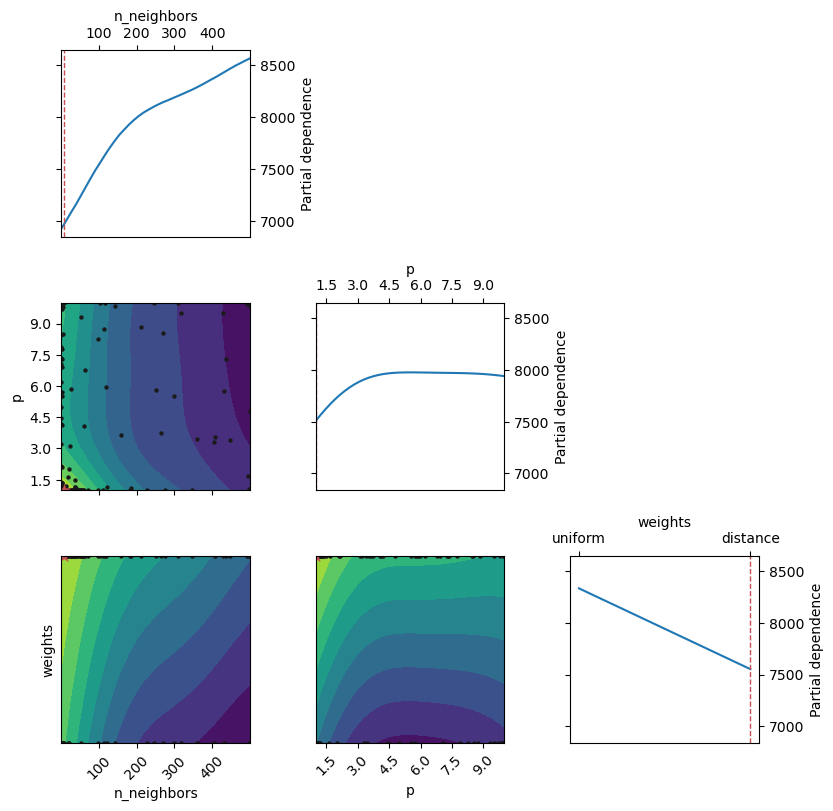

In [139]:
plot_objective(gcv.optimizer_results_[0],
                   dimensions=["n_neighbors", "p", "weights"], size = 3)
plt.show();

Below is the plot showing the cross-validated score computed at each of the 180 hyperparameter values considered for cross-validation.

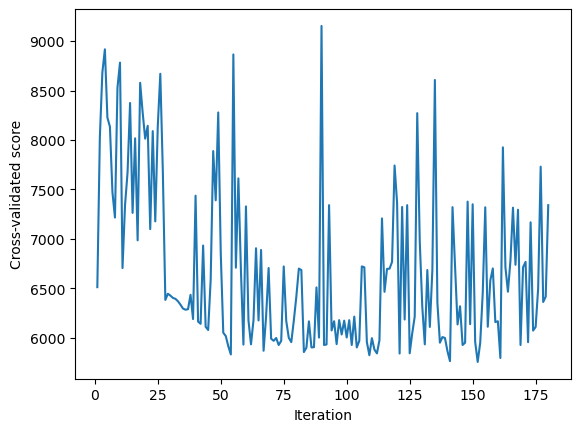

In [155]:
sns.lineplot(x = range(1, 181), y = gcv.optimizer_results_[0]['func_vals'])
plt.xlabel('Iteration')
plt.ylabel('Cross-validated score')
plt.show();

Note that the cross-validated error is close to the optmial value in the 53rd iteration itself. 

The cross-validated error at the 53rd iteration is:

In [149]:
gcv.optimizer_results_[0]['func_vals'][53]

5831.87280274334

The hyperparameter values at the 53rd iterations are:

In [156]:
gcv.optimizer_results_[0]['x_iters'][53]

[15, 1.0, 'distance']

Note that this is the 2nd most optimal hyperparameter value based on `GridSearchCV()`.

The advantages of `BayesSearchCV()` over `GridSearchCV()` and `RandomizedSearchCV()` are:

1. The Bayesian Optimization approach gives the benefit that we can give a much larger range of possible values, since over time we identify and exploit the most promising regions and discard the not so promising ones. Plain grid-search would burn computational resources to explore all regions of the domain space with the same granularity, even the not promising ones. Since we search much more effectively in Bayesian search, we can search over a larger domain space.

2. BayesSearch CV may help us identify the optimal hyperparameter value in fewer iterations if the Gaussian process model estimating the cross-validated score is relatively accurate. However, this is not certain. Grid and random search are completely uninformed by past evaluations, and as a result, often spend a significant amount of time evaluating "bad" hyperparameters.

3. BayesSearch CV is more reliable in cases of a large search space, where random selection may miss sampling values from optimal regions of the search space.

The disadvantages of `BayesSearchCV()` over `GridSearchCV()` and `RandomizedSearchCV()` are:

1. `BayesSearchCV()` has a cost of learning from past data, i.e., updating the model that predicts the cross-validated score after every iteration of evaluating the cross-validated score on a new hyperparameter value. This cost will continue to increase as more and more data is collected. There is no such cost in `GridSearchCV()` and `RandomizedSearchCV()` as there is no learning. This implies that each iteration of `BayesSearchCV()` will take a longer time than each iteration of `GridSearchCV()` / `RandomizedSearchCV()`. Thus, even if `BayesSearchCV()` finds the optimal hyperparameter value in fewer iterations, it may take more time than `GridSearchCV()` / `RandomizedSearchCV()` for the same.

2. The success of `BayesSearchCV()` depends on the predictions and associated uncertainty estimated by the Gaussian process (GP) model that predicts the cross-validated score. The GP model, although works well in general, may not be suitable for certain datasets, or may take a relatively large number of iterations to learn for certain datasets.